Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox.I Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [4]:
%cd /Users/ezb/Jupyter\ notebooks/datasets

/Users/ezb/Jupyter notebooks/datasets


In [5]:
import pandas as pd 

df = pd.read_csv('DC_Properties.csv', low_memory=False)

In [6]:
def datawrangle(x):
    # make copy
    x = x.copy()

    # drop X and Y because they're the same as LONGITUDE and LATITUDE
    x = x.drop(columns=['X', 'Y'])

    # drop redundant or useless columns
    x = x.drop(columns=['Unnamed: 0', 'STATE', 'CITY', 'SOURCE', 'FULLADDRESS', 'NATIONALGRID'])

    # drop null values in price since that's our target
    x = x.dropna(subset=['PRICE'], how='any')

    return x

df = datawrangle(df)

In [7]:
df['PRICE'].describe()

count    9.821600e+04
mean     9.313516e+05
std      7.061325e+06
min      1.000000e+00
25%      2.400000e+05
50%      3.999990e+05
75%      6.520000e+05
max      1.374275e+08
Name: PRICE, dtype: float64

In [8]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

target = 'PRICE'

x = df.drop(columns=target)
y = df[target]

x_trainval, x_test, y_trainval, y_test = train_test_split(
    x, y, test_size=20000, random_state=0
)

x_train, x_val, y_train, y_val = train_test_split(
    x_trainval, y_trainval, test_size=20000, 
    random_state=0
)

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(n_estimators=100,
                          random_state=0,
                          n_jobs=-1
    )
)

pipeline.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['HEAT', 'AC', 'SALEDATE', 'QUALIFIED',
                                      'STYLE', 'STRUCT', 'GRADE', 'CNDTN',
                                      'EXTWALL', 'ROOF', 'INTWALL',
                                      'GIS_LAST_MOD_DTTM', 'ASSESSMENT_NBHD',
                                      'ASSESSMENT_SUBNBHD', 'CENSUS_BLOCK',
                                      'WARD', 'SQUARE', 'QUADRANT'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'HE...
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease

In [9]:
import numpy as np

y_pred_train = pipeline.predict(x_train)
y_pred_val = pipeline.predict(x_val)
    
print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('Validation Root Mean Square Error:', np.sqrt(mean_squared_error(y_val, y_pred_val)))
print('Train Mean Absolute Error:', mean_absolute_error(y_train, y_pred_train))
print('Validation Mean Absolute Error:', mean_absolute_error(y_val, y_pred_val))
print('Train R^2 Score:', r2_score(y_train, y_pred_train))
print('Validation R^2 Score:', r2_score(y_val, y_pred_val))

Train Root Mean Squared Error: 217147.31512392085
Validation Root Mean Square Error: 441043.6721474072
Train Mean Absolute Error: 43545.81857704517
Validation Mean Absolute Error: 119974.21188007064
Train R^2 Score: 0.999040021684584
Validation R^2 Score: 0.9966337963940062


In [32]:
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV

target = 'PRICE'
x = df.drop(columns=target)
y = df[target]

x_trainval, x_test, y_trainval, y_test = train_test_split(
    x, y, test_size=20000, random_state=0
)

x_train, x_val, y_train, y_val = train_test_split(
    x_trainval, y_trainval, test_size=20000, 
    random_state=0
)

transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

x_train_transformed = transformers.fit_transform(x_train)
x_val_transformed = transformers.transform(x_val)

regr_trans = TransformedTargetRegressor(
    regressor=RandomForestRegressor(n_estimators=100,
                          random_state=0,
                          n_jobs=-1),
    transformer=QuantileTransformer(n_quantiles=300,
                                    output_distribution='normal'))

regr_trans.fit(x_train_transformed, y_train)
y_pred = regr_trans.predict(x_val_transformed)


In [33]:
print('Train Accuracy', regr_trans.score(x_train_transformed, y_train))
print('Validation Accuracy', regr_trans.score(x_val_transformed, y_val))

Train Accuracy 0.996318603371561
Validation Accuracy 0.9932635350416942


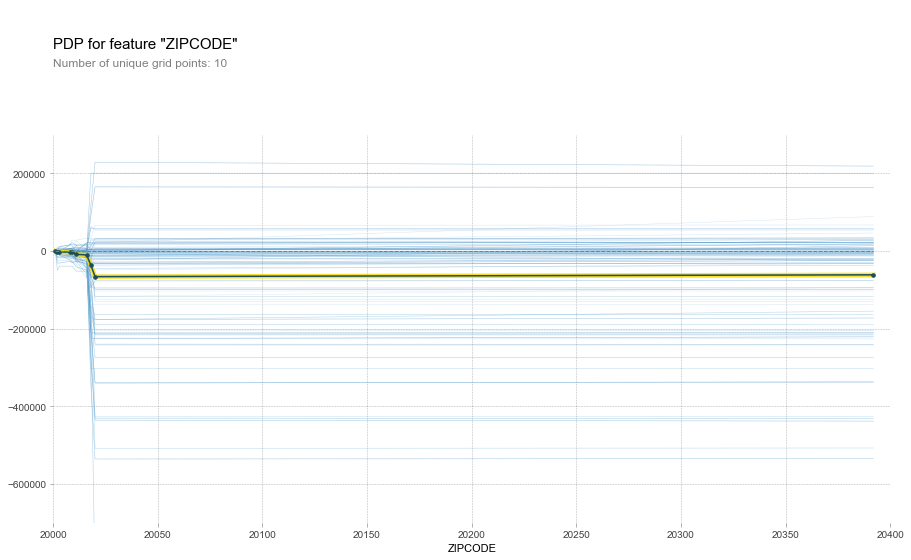

In [35]:
from pdpbox.pdp import pdp_isolate, pdp_plot
import matplotlib.pyplot as plt

feature = 'ZIPCODE'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=x_val, 
    model_features=x_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)
plt.xlim(20000,20400)
plt.ylim(-7e+5, 3e+5);